In [1]:
import rerun as rr
import genjax
import os
import numpy as np
import jax.numpy as jnp
import jax
from b3d import Pose
import b3d
from tqdm import tqdm
import trimesh
import pytest
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
from b3d.bayes3d.image_likelihoods import gaussian_iid_pix_likelihood_vec, threedp3_gmm_likelihood_vec, kray_likelihood_intermediate_vec



In [2]:
## L2 distance test 

PORT = 8812
rr.init("233")
rr.connect(addr=f"127.0.0.1:{PORT}")

In [3]:
## posterior grows as object is moved into distance

In [4]:
mesh_path = os.path.join(
    b3d.get_root_path(), "assets/shared_data_bucket/025_mug/textured.obj"
)
mesh = trimesh.load(mesh_path)
mesh.vertices = mesh.vertices - mesh.vertices.mean(axis=0)

object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_trimesh(mesh)

h,w,fx,fy,cx,cy = 50, 50, 100.0, 100.0, 25.0, 25.0
renderer_scales = jnp.array([1,3,5,7,9])
renderers = [
    b3d.RendererOriginal(scale * h, scale *w, scale * fx, scale * fy, scale * cx, scale * cy, 0.01, 10.0)
    for scale in renderer_scales
]

/opt/conda/envs/b3d2/lib/python3.12/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


In [5]:
linear_pose_from_points = lambda points1, points2, alpha: b3d.Pose.from_position_and_target(
    jnp.array([0.0, -0.8, 0.1]),
    jnp.zeros(3)
).inv() @ b3d.Pose.from_translation((1 - alpha) * points1 + alpha * points2 )



def render_rgbd_many(renderer, vertices, faces, attributes):
    return renderer.render_many(
        vertices,
        faces,
        jnp.concatenate([attributes, vertices[...,-1:]],axis=-1)
    )


In [6]:

# gaussian iid args
gaussian_iid_pix_likelihood_args = {'rgb_tolerance': 50.0,
                   'depth_tolerance': 0.05,
                   'outlier_prob': 0.01}

# GMM args
threedp3_gmm_likelihood_args = {'variance': 0.5,
                   'outlier_prob': 0.1,
                   'outlier_volume': 10**3,
                   'filter_size': 3,
                   'intrinsics': (100,100,200.0,200.0,50.0,50.0,0.01,10.0,)}

# ray-tracing likelihood args
kray_likelihood_args = {'color_tolerance': 50.0, #100
                    'depth_tolerance': 0.01, #0.005
                    'inlier_score': 2.5,
                    'outlier_prob': 0.005,
                    'multiplier': 1.0, # 10000.0
                    'intrinsics': (100,100,200.0,200.0,50.0,50.0,0.01,10.0,)}



Text(0, 0.5, 'Posterior Probability')

<Figure size 640x480 with 0 Axes>

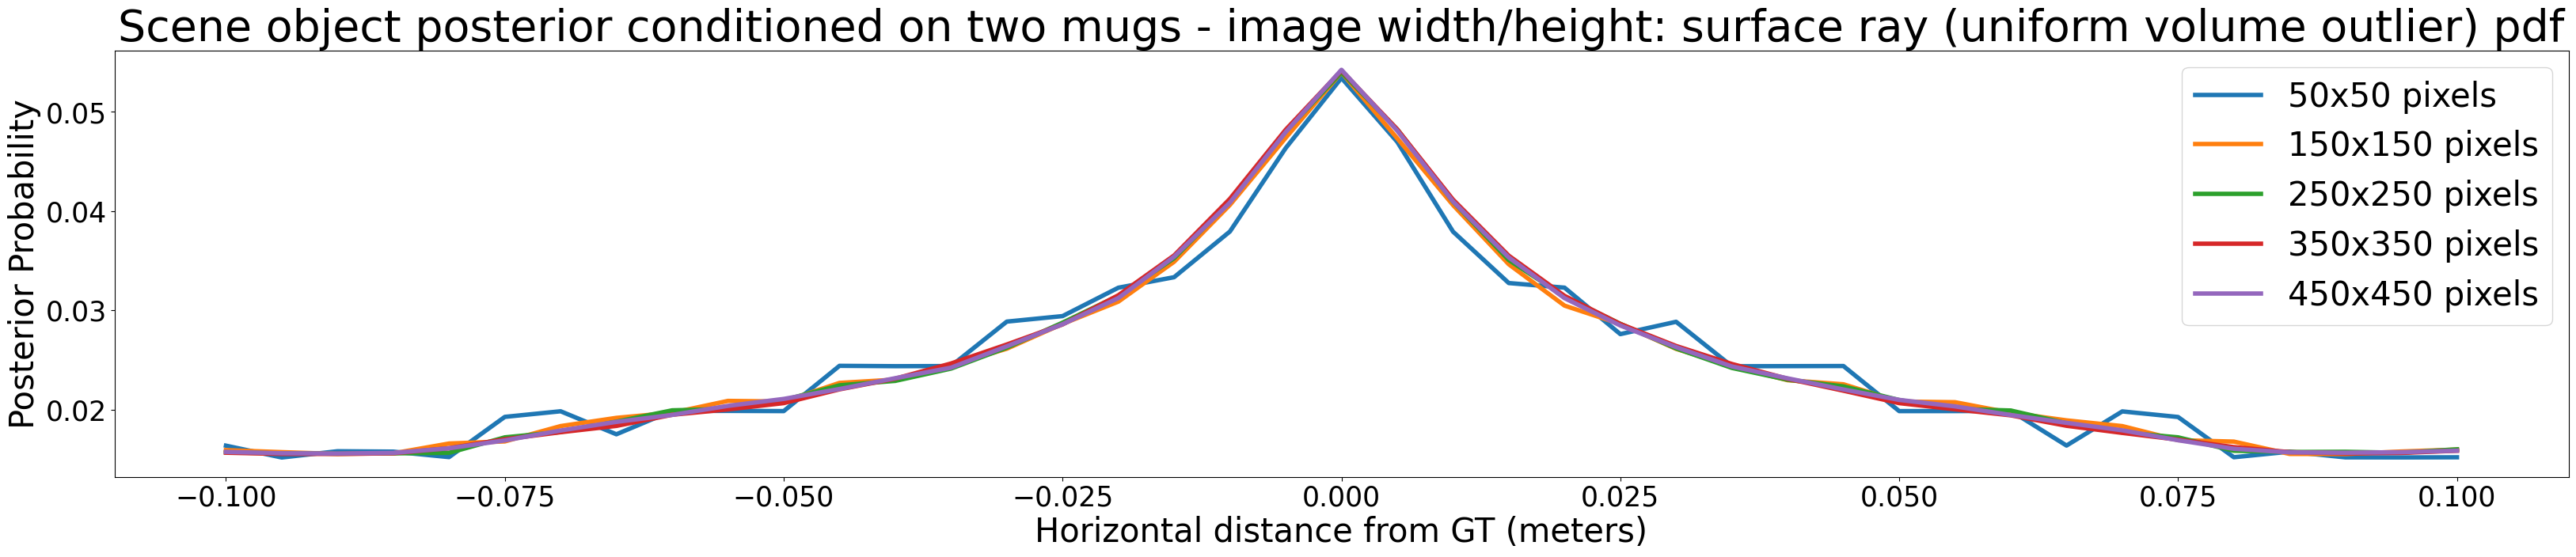

In [7]:
# sweep y from -0.25 to 1.5

plt.figure()
fig, axes = plt.subplots(1, 1, figsize=(40, 7))
gt_images = []


for r_ind, renderer in enumerate(renderers):
    distance = 0.25
    point1 = jnp.array([-0.1,distance,0])
    point2 = jnp.array([0.1,distance,0])

    # 0.1 is horizontal range

    alphas = jnp.linspace(0, 1, 41)
    vec_fun = jax.vmap(linear_pose_from_points, (None, None, 0))

    linear_poses = vec_fun(point1, point2, alphas)
    transformed_vertices = jax.vmap(lambda i: linear_poses[i].apply(object_library.vertices))(jnp.arange(len(linear_poses)))

    N = len(linear_poses)


    images = render_rgbd_many(renderer,transformed_vertices,object_library.faces, jnp.tile(object_library.attributes, (N,1,1)))
    rendered_imgs = images
    gt_image = images[N//2,...,:3]
    gt_images.append(gt_image)

    gt_image_depth = np.array(images[N//2,...,3])
    gt_image_depth[gt_image_depth==0] = 10.0
    gt_image_depth = jnp.array(gt_image_depth)


    observed_image  =  jnp.concatenate([gt_image, gt_image_depth[...,None]], axis=-1)


    ray_outlier_logpdfs, _ = kray_likelihood_intermediate_vec(observed_image, rendered_imgs,  kray_likelihood_args)


    distances = linear_poses.pos[:,0]

    im_dim_str = str(renderer_scales[r_ind] * w)
    axes.plot(distances, b3d.normalize_log_scores(ray_outlier_logpdfs), alpha=1, linewidth=4, label=im_dim_str+'x'+im_dim_str+' pixels')
    num_ticks = 3

title = "Scene object posterior conditioned on two mugs - image width/height: surface ray (uniform volume outlier) pdf" 
plt.title(title, fontsize=40)
axes.tick_params(axis='x', labelsize=25)
axes.tick_params(axis='y', labelsize=25)
plt.legend(fontsize=30)
plt.xlabel("Horizontal distance from GT (meters)", fontsize=30)
plt.ylabel("Posterior Probability", fontsize=30)


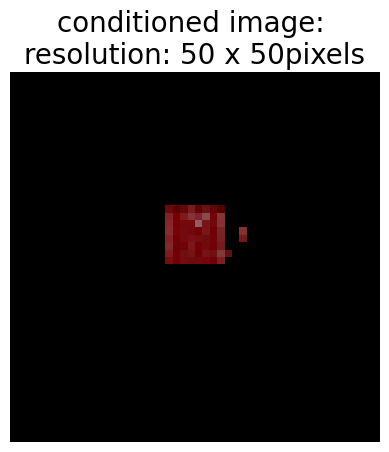

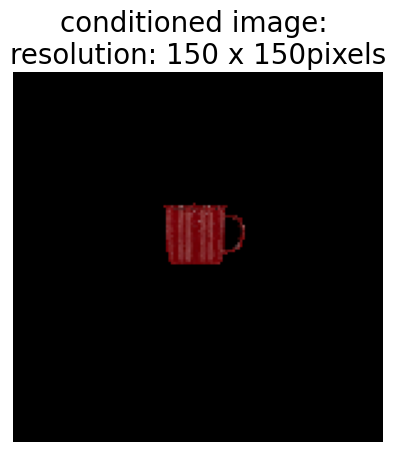

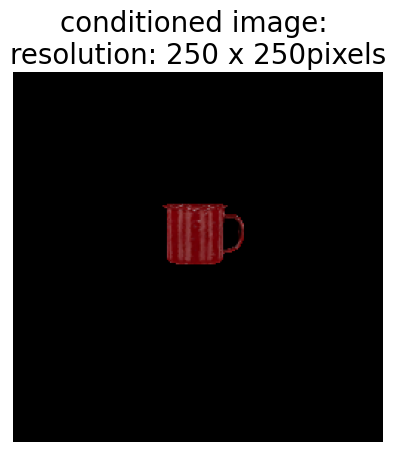

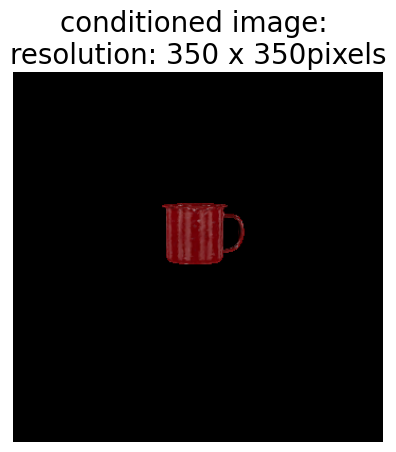

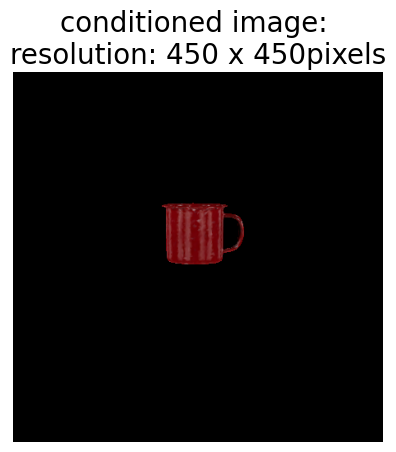

In [11]:
for r_ind, _ in enumerate(renderers):
    im_dim_str = str(renderer_scales[r_ind] * w)
    plt.figure()
    plt.title("conditioned image: \nresolution: "+im_dim_str+' x '+im_dim_str+'pixels', fontsize=20)
    plt.imshow(gt_images[r_ind])
    plt.axis('off')

Text(0, 0.5, 'Posterior Probability')

<Figure size 640x480 with 0 Axes>

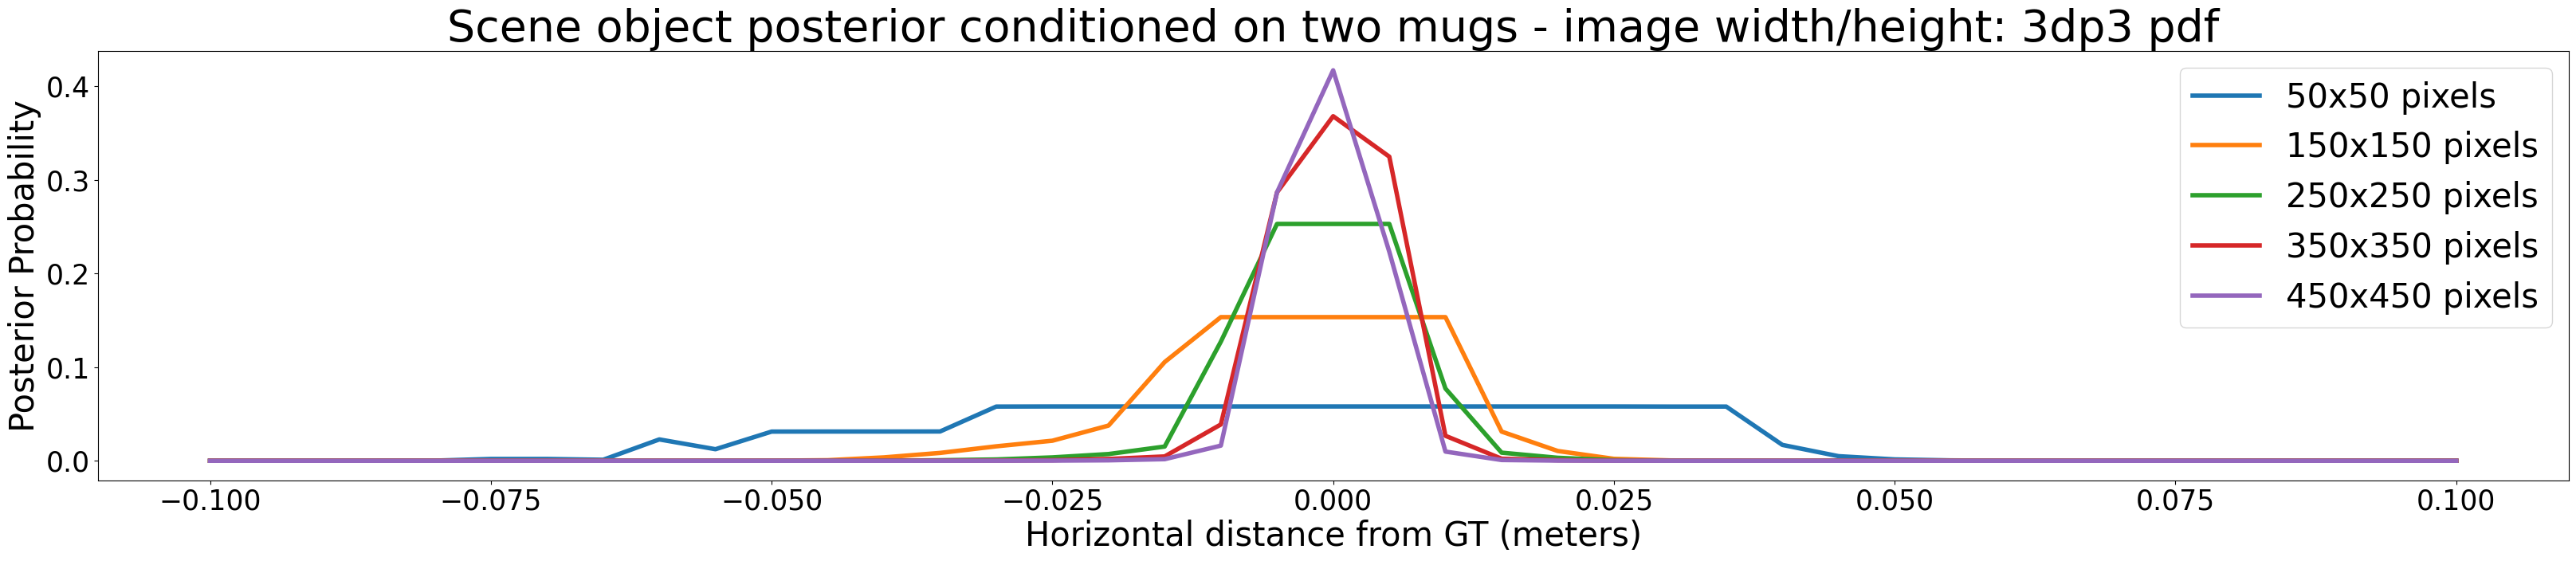

In [9]:
# sweep y from -0.25 to 1.5

plt.figure()
fig, axes = plt.subplots(1, 1, figsize=(40, 7))

for r_ind, renderer in enumerate(renderers):
    distance = 0.25
    point1 = jnp.array([-0.1,distance,0])
    point2 = jnp.array([0.1,distance,0])

    # 0.1 is horizontal range

    alphas = jnp.linspace(0, 1, 41)
    vec_fun = jax.vmap(linear_pose_from_points, (None, None, 0))

    linear_poses = vec_fun(point1, point2, alphas)
    transformed_vertices = jax.vmap(lambda i: linear_poses[i].apply(object_library.vertices))(jnp.arange(len(linear_poses)))

    N = len(linear_poses)


    images = render_rgbd_many(renderer,transformed_vertices,object_library.faces, jnp.tile(object_library.attributes, (N,1,1)))
    rendered_imgs = images
    gt_image = images[N//2,...,:3]
    gt_image_depth = np.array(images[N//2,...,3])
    gt_image_depth[gt_image_depth==0] = 10.0
    gt_image_depth = jnp.array(gt_image_depth)

    observed_image  =  jnp.concatenate([gt_image, gt_image_depth[...,None]], axis=-1)

    threedp3_logpdfs, _ = threedp3_gmm_likelihood_vec(observed_image, rendered_imgs,  threedp3_gmm_likelihood_args)


    distances = linear_poses.pos[:,0]
    im_dim_str = str(renderer_scales[r_ind] * w)
    axes.plot(distances, b3d.normalize_log_scores(threedp3_logpdfs), alpha=1, linewidth=4, label=im_dim_str+'x'+im_dim_str+' pixels')
    num_ticks = 3

title = "Scene object posterior conditioned on two mugs - image width/height: 3dp3 pdf" 
plt.title(title, fontsize=40)
plt.legend(fontsize=30)
axes.tick_params(axis='x', labelsize=25)
axes.tick_params(axis='y', labelsize=25)
plt.xlabel("Horizontal distance from GT (meters)", fontsize=30)
plt.ylabel("Posterior Probability", fontsize=30)


Text(0, 0.5, 'Posterior Probability')

<Figure size 640x480 with 0 Axes>

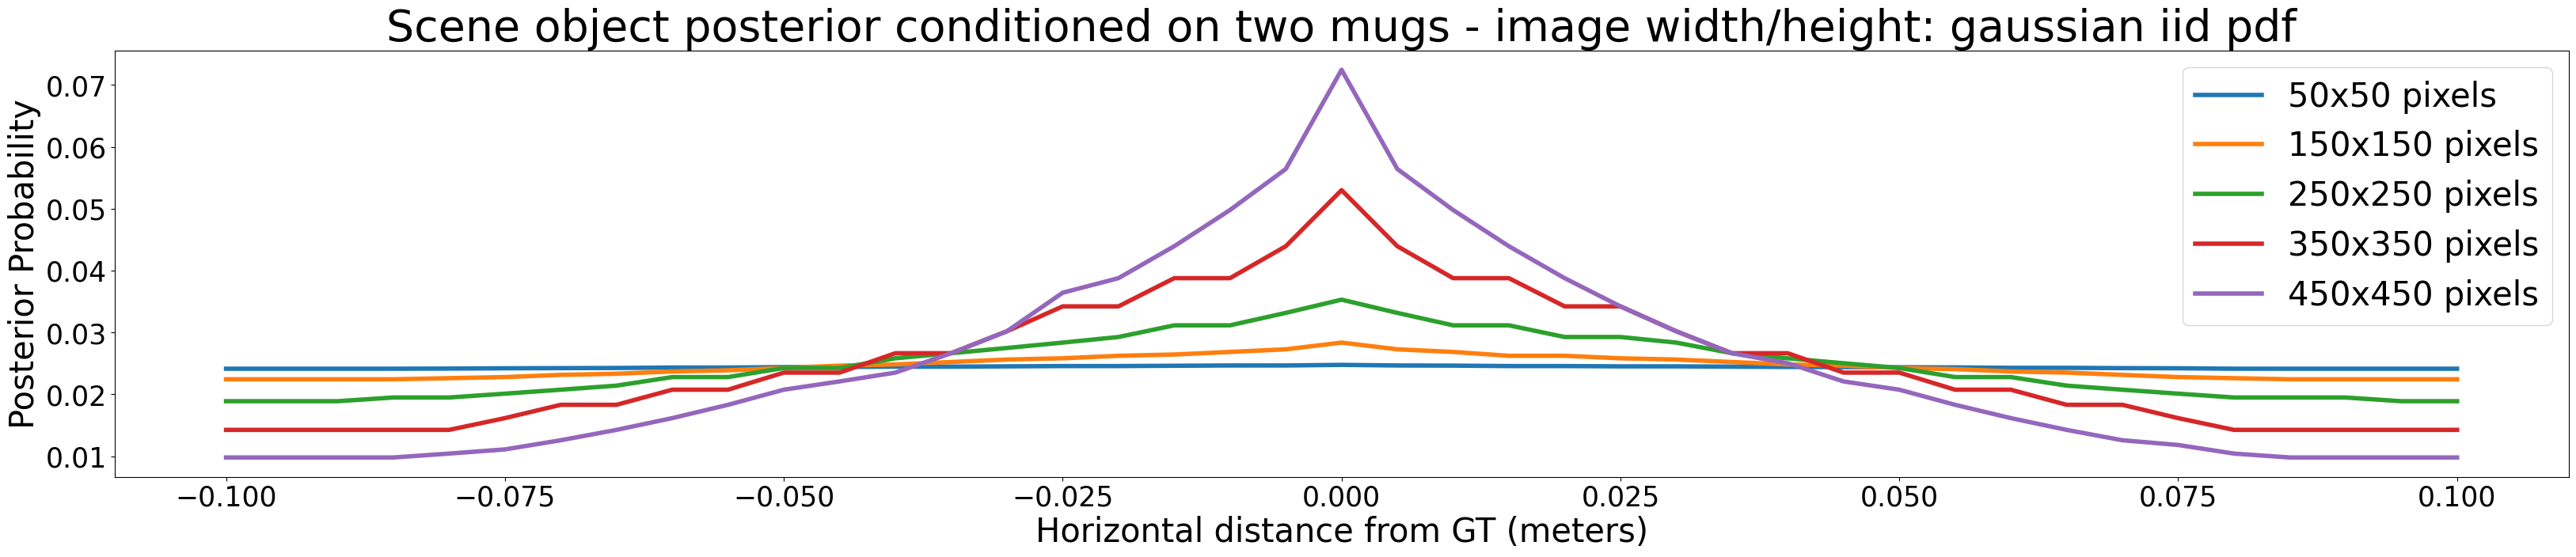

In [10]:
# sweep y from -0.25 to 1.5

plt.figure()
fig, axes = plt.subplots(1, 1, figsize=(40, 7))

for r_ind, renderer in enumerate(renderers):
    distance = 0.25
    point1 = jnp.array([-0.1,distance,0])
    point2 = jnp.array([0.1,distance,0])

    # 0.1 is horizontal range

    alphas = jnp.linspace(0, 1, 41)
    vec_fun = jax.vmap(linear_pose_from_points, (None, None, 0))

    linear_poses = vec_fun(point1, point2, alphas)
    transformed_vertices = jax.vmap(lambda i: linear_poses[i].apply(object_library.vertices))(jnp.arange(len(linear_poses)))

    N = len(linear_poses)


    images = render_rgbd_many(renderer,transformed_vertices,object_library.faces, jnp.tile(object_library.attributes, (N,1,1)))
    rendered_imgs = images
    gt_image = images[N//2,...,:3]
    gt_image_depth = np.array(images[N//2,...,3])
    gt_image_depth[gt_image_depth==0] = 10.0
    gt_image_depth = jnp.array(gt_image_depth)


    observed_image  =  jnp.concatenate([gt_image, gt_image_depth[...,None]], axis=-1)


    gaussian_logpdfs, _ = gaussian_iid_pix_likelihood_vec(observed_image, rendered_imgs,  gaussian_iid_pix_likelihood_args)
    distances = linear_poses.pos[:,0]
    im_dim_str = str(renderer_scales[r_ind] * w)
    axes.plot(distances, b3d.normalize_log_scores(gaussian_logpdfs), alpha=1, linewidth=4, label=im_dim_str+'x'+im_dim_str+' pixels')

    num_ticks = 3

title = "Scene object posterior conditioned on two mugs - image width/height: gaussian iid pdf" 
plt.title(title, fontsize=40)
plt.legend(fontsize=30)
axes.tick_params(axis='x', labelsize=25)
axes.tick_params(axis='y', labelsize=25)
plt.xlabel("Horizontal distance from GT (meters)", fontsize=30)
plt.ylabel("Posterior Probability", fontsize=30)
